In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from sklearn.model_selection import train_test_split

In [2]:
def fetch_data(file_path):
    data = loadmat(file_path)
    return data['X'], data['y']

In [3]:
train_file_path= 'train_32x32.mat'
test_file_path= 'test_32x32.mat'

train_X, train_y = fetch_data(train_file_path)
test_X, test_y = fetch_data(test_file_path)

print("Training Data", train_X.shape, train_y.shape)
print("Test Data", test_X.shape, test_y.shape)

Training Data (32, 32, 3, 73257) (73257, 1)
Test Data (32, 32, 3, 26032) (26032, 1)


Convert structure from 
(width, height, channel, size)
to
(size, width, height, channel)
I do this by transposing them

In [4]:
#transposing
train_X, train_y = train_X.transpose((3,0,1,2)), train_y[:,0]
test_X, test_y = test_X.transpose((3,0,1,2)), test_y[:,0]

print("Training Data", train_X.shape)
print("Test Data",test_X.shape)


number_of_images = train_X.shape[0] + test_X.shape[0]

print("Total number of images", number_of_images)


Training Data (73257, 32, 32, 3)
Test Data (26032, 32, 32, 3)
Total number of images 99289


In [5]:
train_y

array([1, 9, 2, ..., 1, 6, 9], dtype=uint8)

In [6]:
#for plotting
%matplotlib inline
plt.rcParams['figure.figsize'] = [16,4]

def image_plot(image, label, row, col):
    
    fig, axes = plt.subplots(row, col)
    
    for i, ax in enumerate(axes.flat): 
        if image[i].shape == (32, 32, 3):
            ax.imshow(image[i])
        else:
            ax.imshow(image[i,:,:,0])
        ax.set_xticks([]); ax.set_yticks([])
        ax.set_title(label[i])

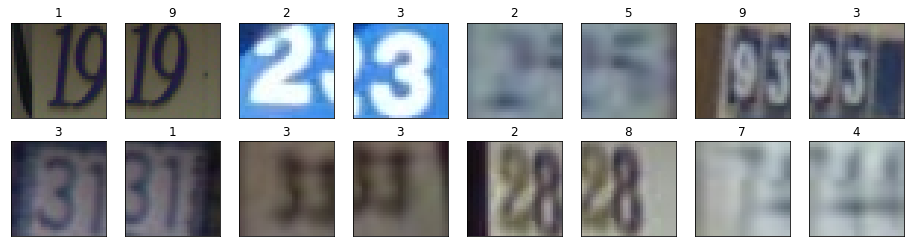

In [7]:
#plot sample training images
image_plot(train_X, train_y, 2, 8)


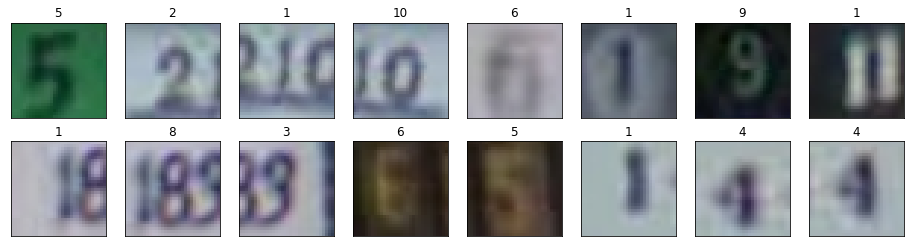

In [8]:
#plot sample test images
image_plot(test_X, test_y, 2, 8)

We see here that the labels are from 1-10

In [9]:
print(np.unique(train_y))

[ 1  2  3  4  5  6  7  8  9 10]


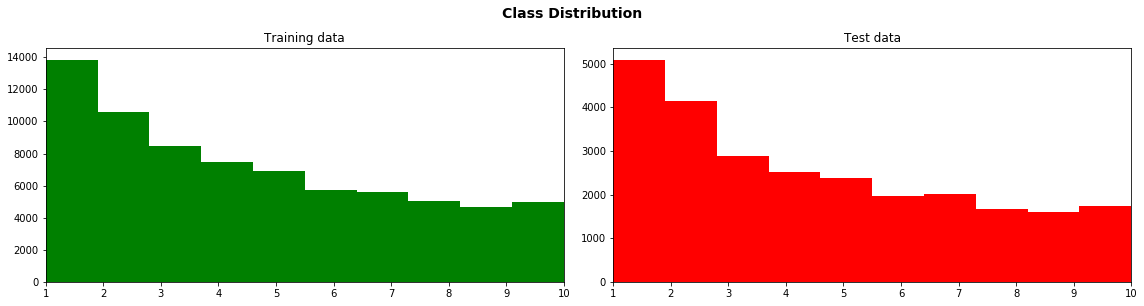

In [10]:

fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True)

fig.suptitle('Class Distribution', fontsize=14, fontweight='bold', y=1.05)

ax1.hist(train_y, bins=10, color='g')
ax1.set_title("Training data")
ax1.set_xlim(1, 10)

ax2.hist(test_y, color='r', bins=10)
ax2.set_title("Test data")

fig.tight_layout()

Set the class label '10' to '0'

In [11]:
train_y[train_y == 10] = 0
test_y[test_y == 10] = 0



Now labels are 0-9

In [12]:
print(np.unique(train_y))

[0 1 2 3 4 5 6 7 8 9]


In [13]:
#train test split
train_X, val_X, train_y, val_y = train_test_split(train_X, train_y, test_size=0.13, random_state=7)

Visualize new distribution 

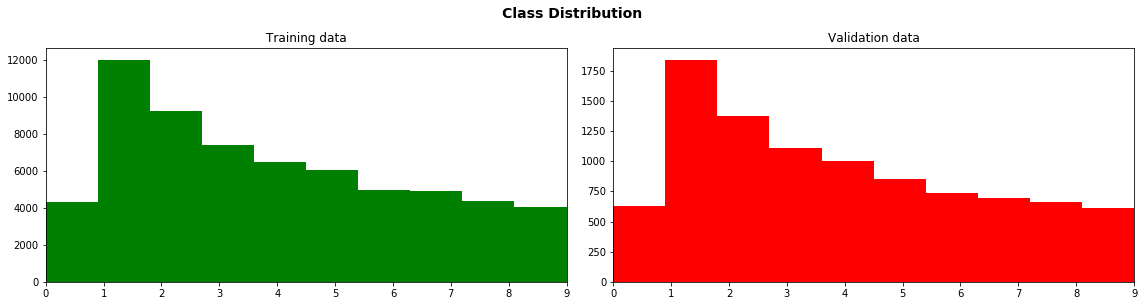

In [14]:
#review this
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True)

fig.suptitle('Class Distribution', fontsize=14, fontweight='bold', y=1.05)

ax1.hist(train_y, bins=10,color='g')
ax1.set_title("Training data")
ax1.set_xlim(0, 9)

ax2.hist(val_y, color='r', bins=10)
ax2.set_title("Validation data")

fig.tight_layout()


Convert to GrayScale 

In [15]:
#Y = 0.2990R + 0.5870G + 0.1140B 
def convert_to_greyscale(img):
    #turn images to greyscale
    return np.expand_dims(np.dot(img, [0.2990, 0.5870, 0.1140]), axis=3)

In [16]:
train_gs = convert_to_greyscale(train_X).astype(np.float32)
test_gs = convert_to_greyscale(test_X).astype(np.float32)
val_gs = convert_to_greyscale(val_X).astype(np.float32)

#No longer needed since values are converted to greyscale
del train_X, test_X, val_X

Before normalization

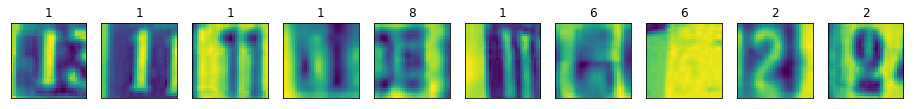

In [17]:
image_plot(train_gs, train_y, 1, 10)

Normalization

In [18]:
# Calculate tmean and std on training data
trainData_mean = np.mean(train_gs, axis=0)
trainData_std = np.std(train_gs, axis=0)

# Calculate difference equally across all the splits
norm_train_gs = (train_gs - trainData_mean) / trainData_std
norm_test_gs = (test_gs - trainData_mean)  / trainData_std
norm_val_gs = (val_gs - trainData_mean) / trainData_std


After normalization

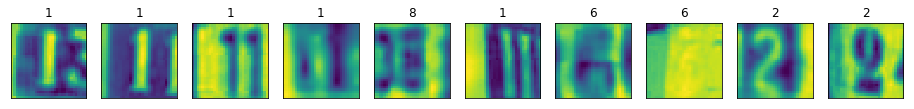

In [19]:
image_plot(norm_train_gs, train_y, 1, 10)


Hot one encoding ensure labels are suitable for CNN classification

In [20]:
from sklearn.preprocessing import OneHotEncoder
 
enc = OneHotEncoder().fit(train_y.reshape(-1, 1))
train_y = enc.transform(train_y.reshape(-1, 1)).toarray()
test_y = enc.transform(test_y.reshape(-1, 1)).toarray()
val_y = enc.transform(val_y.reshape(-1, 1)).toarray()

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [21]:
import h5py

outfile = h5py.File('StreetViewHouseNumbersGS.h5', 'w')

#datasets
outfile.create_dataset('train_X', data=norm_train_gs)
outfile.create_dataset('train_y', data=train_y)
outfile.create_dataset('test_X', data=norm_test_gs)
outfile.create_dataset('test_y', data=test_y)
outfile.create_dataset('val_X', data=norm_val_gs)
outfile.create_dataset('val_y', data=val_y)
outfile.close()